# Connectivity analysis and stochastic controls

The structure of a connectome is often characterized by reporting the values of connectivity metrics, where a given metric captures some aspect of its organization. At its simplest, this can be for example the connection probability, but more complex measures are also applied.

Formally, such reports can confirm or (more often) reject a connectivity algorithm to be a good model of a connectome. This is, because for simple algorithms the ranges of values reached are well known. Therefore, a value outside the range would reject the model. 

However, there can still be many other, very simple algorithms that can explain the results. It is important to investigate them before coming to strong conclusions.

We will illustrate this idea in this notebook

In [ ]:
!pip install numpy
!pip install pandas
!pip install Connectome-Utilities
!pip install connectome-analysis
!pip install scipy

In [ ]:
import numpy
import pandas
import conntility
import connalysis
from scipy import sparse

from matplotlib import pyplot as plt

## Common neighbor bias

It has been observed that connectivity in brain networks is biased for connections between neurons with many _common neighbors_. A "neighor" of a neuron in this context is another neuron that is connected to the first; a "common neighbor" of a pair of neurons is a third neuron that is connected to both of them.

Perin et al., 2012, PNAS found the following:

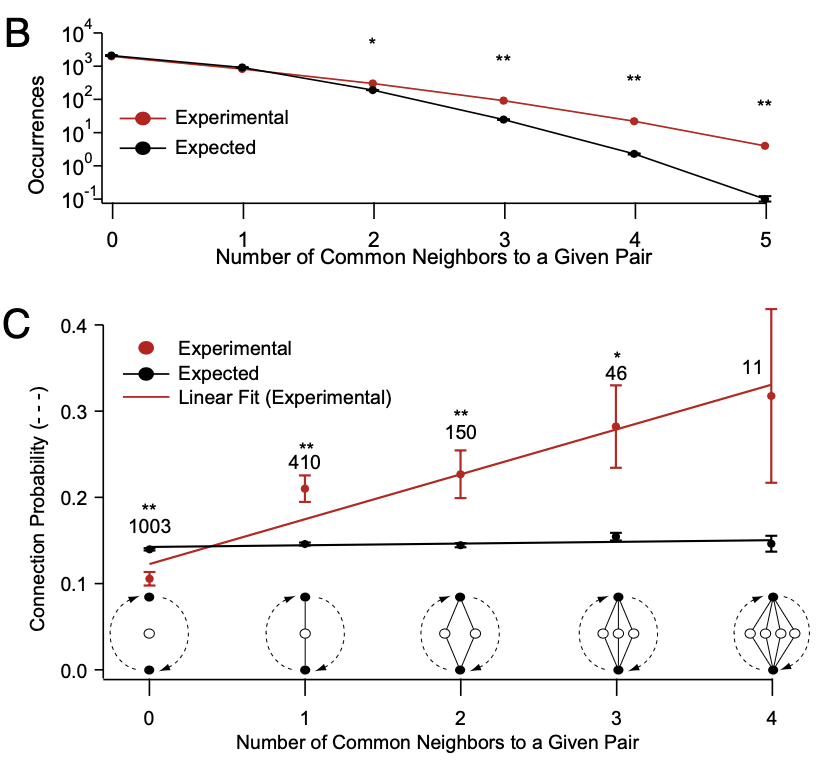

In panel B we see that there are more common neighbors for pairs than "expected". Expectation in this context is the distribution of the number of common neighbors between pairs in an "Erdos-Renyi" graph. What Erdos-Renyi means will be explained further below.

In panel C we see that the probability that the pair is connected strongly depends on the number of common neighbors between them.

### The meaning of the measure

The phenomenon is often interpreted as evidence of connection clustering. I.e., of the presence of small groups of neurons that are much more tightly interconnected than expected. (In fact, it is closely related to another measure called "clustering coefficient"). 

Formally, the measure demonstrates a statistical dependence between the existence of one connection and another. The existence of the connections to the common neighbors influences the probability that the connection between the pair exists. 

### Investigate
Here, we investigate this proposed phenomenon in some stochastically-generated connectomes and a real connectome.

We begin by implementing a function that analyzes how much connection probability increases with common neighbors.
It takes as input the representation of the connectome as a graph as input. Specifically, its 'adjacency matrix', represented as a scipy.sparse matrix. That is a N x N matrix, where N is the number of neurons in the connectome, where the entry at [i, j] is True iff there is a connection from neuron #i to neuron #j.

An additional input is the direction of connectivity considered for neighbors. Previously, we defined a neuron that is connected to another neuron, but did not specify the direction of the connection: Is it innervated by or innervating the other neuron. In this function, this is made explicit, considering either "afferent" or "efferent" neighbors. The final input is the minimum number of pairs required for a valid connection probability. If, for a given number of common neighbors fewer than that number of pairs are found, no connection probability sample is recorded.

The function returns a pandas.Series with the number of common neigbors as index and the corresponding connection probability as values.



In [ ]:
def connection_probability_vs_cn(m, direction="efferent", min_num_smpl=100):
    # Convert True/False to 1.0/0.0.
    m = m.astype(float).tocsr()
    # We will below assume that efferent neighbors be considered. For the afferent case we simply transpose.
    if direction == "afferent":
        m = m.transpose()
    elif direction != "efferent":
        raise ValueError("Unknow value for direction: {0}".format(direction))
    
    # We calculcate a mtrix where the entry at [i,j] is the number of common neighbors between neuron #i and #j.
    CN = m * m.transpose()
    # From sparse to dense representatiojn
    CN = numpy.array(CN.todense())
    # Entries along the main diagonal are meaningless. To avoid them affecting the results we set them to NaN.
    numpy.fill_diagonal(CN, numpy.nan)

    # Iterate over the possible number of common neighbors
    max_cn = int(numpy.nanmax(CN))
    p_per_cn = []
    for cn in range(max_cn + 1):
        # Are there enough pairs with that number of common neighbors?
        if (CN == cn).sum() >= min_num_smpl:
            # Then calculate the connection probability for the pairs and report it
            p = m[CN == cn].mean()
            p_per_cn.append((cn, p))
    df = pandas.DataFrame(p_per_cn, columns=["cn", "p"])
    return df.set_index("cn")["p"]


An Erdos-Renyi or ER graph is a very simple model. It is defined by only two parameters, its size, i.e. number of nodes (neurons), and its connection probability. An edge exists between any single pair with the specified probability and this process is statistically independent. 

Below, we call the two parameters "n" and "p" and use a functions in the "connalysis" package to generate a random instance. If you wish, you can write your own implementation instead, it does not take much code.

Then, we analyze the common neigbor bias of the results. What result would we expect? As mentioned above in biological neuronal networks we observe an increase of connection probability with common neighbors that is not observed in the Erdos-Renyi networks. In fact, in Erdos-Renyi, we expect no increase at all. Based on the description above, each edge exists with the specified probability and that process is independent of neighboring edges.

In [ ]:
p_per_cn = {}

n = 1000
p = 0.03
min_num_smpl = 100

mat_er = connalysis.randomization.run_ER(n, p).tocsr()

p_per_cn["Erdos-Renyi"] = connection_probability_vs_cn(mat_er)


for k, v in p_per_cn.items():
    plt.plot(v, marker="o", label=k)
plt.legend()
plt.gca().set_xlabel("Number of common neighbors")
plt.gca().set_ylabel("Connection probability")

Indeed we see no particular increase or decrease, beyond some minor stochastic variability that is expected.
The connection probability hovers around the value we prescribed earlier (i.e., "p") everywhere.

## Common neighbors in distance-dependent connectivity
Let's see how this plays out in a different type of stochastic network. We build one with distance-dependent connection probability. It is constructed according to the following rule: Connections between pairs are formed statistically independently; a connection exists with a probability that depends on the distance between the pair according to the following formula:
P(i, j) = p_scale * exp(-p_exponent * D(i, j))

We begin by setting values for the two parameters (p_scale, p_exponent) and plotting the connection probability function.

Additionally, "spatial_scale" defines the overall spatial dimensions used. To define distances between neurons, each neuron is associated with a random location inside a cube of that size.

Note: Units for locations and distances are um.


In [ ]:
spatial_scale = 400.0
p_scale = 0.5
p_exponent = 0.015
ndims = 3


example_dists = numpy.linspace(0, 600, 100)
plt.plot(example_dists, p_scale * numpy.exp(-p_exponent * example_dists))

We generate the random neuron locations and build an instance of the stochastic network. Once again, feel free to implement the function generating the network yourself.

Upon analyzing its common neighbor bias, we see that connection probability increases quite drastically with common neighbor count!

In [ ]:
nrn_locs = numpy.random.rand(n, ndims) * spatial_scale
mat_dd = connalysis.randomization.run_DD2(n, p_scale, p_exponent, nrn_locs).tocsr()

p_per_cn["Distance-dependent"] = connection_probability_vs_cn(mat_dd)

for k, v in p_per_cn.items():
    plt.plot(v, marker="o", label=k)
plt.legend()
plt.gca().set_xlabel("Number of common neighbors")
plt.gca().set_ylabel("Connection probability")

This is puzzling: As stated above, this is evidence of statistical dependence between connections. But we know for a fact that in this model connections are formed independently, by construction.

Additionally, it is interpreted as evidence for the presence of clusters, but we know that connectivity is homogeneous with no determined clusters.

Why is that?

While connections are formed independently, their probabilities are not uniform. A pair of neurons with many common neighbors is more likely to be right next to each other than on opposite ends of the volume. Hence, it is also more likely to be connected than average.

Below, we begin by calculating the probability distributions of distances of connected and unconnected pairs.

In [ ]:
from scipy.spatial import distance

dist_bin_borders = numpy.linspace(1E-4, 650, 101)
dist_bin_centers = 0.5 * (dist_bin_borders[:-1] + dist_bin_borders[1:])

D = distance.pdist(nrn_locs)
p_per_bin = p_scale * numpy.exp(-p_exponent * dist_bin_centers) # P(connected | distance)
distr_of_distances = numpy.histogram(D, bins=dist_bin_borders)[0] / len(D) # P(distance)
overall_p = mat_dd.mean() # P(connected)

# P(distance | connected) = P(connected | distance) * P(distance) / P(connected)
dist_cond_connected = p_per_bin * distr_of_distances / overall_p
dist_cond_unconnected = (1.0 - p_per_bin) * distr_of_distances / (1.0 - overall_p)

# We plot the distributions of distances
plt.plot(dist_bin_centers, dist_cond_connected,
         label="For connected pairs")
plt.plot(dist_bin_centers, dist_cond_unconnected,
         label="For unconnected pairs")
plt.legend()
plt.gca().set_xlabel("Distance (um)"); plt.gca().set_ylabel("P")

Now consider a pair of neurons, A and B. If A and B are connected, their distance follows the blue curve above, otherwise the orange curve.

We introduce a third neuron C that is connected to B:

A -?-> B --> C

Hence, the distance between B and C follows the blue curve.

From elementary geometry, we know that the distance between A and C is constrained by the sum of distances between A and B, and B and C:

D(A, C) <= D(A, B) + D(A, C)

We can numerically calculate that upper limit

In [ ]:
# For all combinations of D(A,B) and D(A,C) their sum
dist_sum_samples = dist_bin_centers.reshape((-1, 1)) + dist_bin_centers.reshape((1, -1))
# For all combinations of D(A,B) and D(A,C) their probability, if A and B are connected (=product of probabilities)
dist_sum_prob_ab_connected = dist_cond_connected.reshape((-1, 1)) * dist_cond_connected.reshape((1, -1))
# For all combinations of D(A,B) and D(A,C) their probability, if A and B are unconnected
dist_sum_prob_ab_unconnected = dist_cond_connected.reshape((-1, 1)) * dist_cond_unconnected.reshape((1, -1))

sum_prob_connected = []
sum_prob_unconnected = []
for a, b in zip(dist_bin_borders[:-1], dist_bin_borders[1:]):
    in_bin = (dist_sum_samples >= a) & (dist_sum_samples < b)
    sum_prob_connected.append(
        dist_sum_prob_ab_connected[in_bin].sum()
    )
    sum_prob_unconnected.append(
        dist_sum_prob_ab_unconnected[in_bin].sum()
    )

# We plot the distributions of distances
plt.plot(dist_bin_centers, sum_prob_connected,
         label="For A connected to B")
plt.plot(dist_bin_centers, sum_prob_unconnected,
         label="For A not connected to B")
plt.legend()
plt.gca().set_xlabel("D(A,B) + D(B,C) (um)"); plt.gca().set_ylabel("P")


While this is only an upper limit for D(A, C), we see that it is lower if A and B are connected. 

Therefore, if A and B are connected, A and C are more likely to be connected!

This would turn C into a common neighbor of A and B. Such an effect increases the number of common neighbors found between connected pairs. 

Furthermore, it also demonstrates stochastic dependence between connections: The presence or absence of A -> C has been shown to depend on A -> B existing.

## Networks with long-tailed degree distributions

Biological neuronal networks have been demonstrated to have long-tailed degree distributions. (Degree refers to the number of connections of a neuron. Out-degree to its number of outgoing connections, in-degree to the incoming connections.)

That is, the number of connections they form follow a distribution such as the geometric distribution.

We build a network according to that principle.

In [ ]:
from scipy.stats import geom

# We build a geometric probability distribution for degrees. 
# The mean of the distribution should be the expected degree of the Erdos-Renyi network we built above.
# This makes the networks overall comparable.
# The expected degree is easy to calculate as simply p * (n - 1).
distr = geom(1 / (p * (n - 1)))
# For each neuron a randomly draw target degree.
degs = distr.rvs(n)

# For each neuron, we randomly pick the generated number from all possible partners.
indices = [numpy.random.choice(numpy.setdiff1d(numpy.arange(n), _i), _deg, replace=False)
           for _i, _deg in enumerate(degs)]
# Turn the result into a sparse matrix representation.
indptr = numpy.cumsum([0] + [len(_idx) for _idx in indices])
mat_degs = sparse.csr_matrix((numpy.ones(indptr[-1]), numpy.hstack(indices), indptr))

p_per_cn["Degree-distribution"] = connection_probability_vs_cn(mat_degs)

for k, v in p_per_cn.items():
    plt.plot(v, marker="o", label=k)
plt.legend()
plt.gca().set_xlabel("Number of common neighbors")
plt.gca().set_ylabel("Connection probability")

Once again, we see an increase with common neighbor count.

Hypothesis: If a pair of neurons has many common neighbors, they are both more likely to be neurons with a high degree. This also makes them more likely to be connected to each other.

Based on this hypothesis we can make a prediction. If you read the code generating the stochastic network closely, you may notice that it generates a geometrically distributed out-degree, but the in-degree is not long-tailed:

In [ ]:
outdegs = numpy.array(mat_degs.sum(axis=1))[:, 0]
indegs = numpy.array(mat_degs.sum(axis=0))[0]

plt.plot(pandas.Series(outdegs).value_counts().sort_index(), label="Out-degree")
plt.plot(pandas.Series(indegs).value_counts().sort_index(), label="In-degree")

plt.gca().set_xlabel("Degree"); plt.gca().set_ylabel("Number of pairs")

Consequently, the common neighbor bias should be absent if we consider _afferent_ common neighbors instead of efferent ones. 

In [ ]:
p_per_cn["Degree-distribution - afferent"] = connection_probability_vs_cn(mat_degs, direction="afferent")

for k, v in p_per_cn.items():
    plt.plot(v, marker="o", label=k)
plt.legend()
plt.gca().set_xlabel("Number of common neighbors")
plt.gca().set_ylabel("Connection probability")

We see that a common neighbor bias can be apparent in distance dependent networks and networks with long-tailed degree distributions, even if they contain no neuron clusters.

This demonstrates the following:
If a researcher introduces a measure, such as the common neighbor bias, and shows that its value is higher in a network than expected in an Erdos-Renyi network, then they have rejected the Erdos-Renyi network as a model for their network. But they have shown nothing beyond that. They may be tempted to elevate the concepts used in their network measure (such as common neighbors) to a core fundamental principle of a new network algorithm, but that is premature.

### Improving the measure

Does that mean the common neighbor bias is useless for characterizing a connectome? No, but one has to consider stronger control models than the Erdos-Renyi network and compare them as well.

Below, we define a function that takes a connectome (an adjacency matrix) as input and returns a stochastically generated control connectome with the same distance-dependence of connectivity.

Then, we build 10 instances and compare their behavior to the original connectome. When we use as the original connectome the distance-dependent connectome we built earlier, we see that it behaves exactly like the controls.

In [ ]:
def build_distance_dependent_control(mat, locations, bin_size_um=20.0):
    locs_df = pandas.DataFrame(locations, columns=["x", "y", "z"])
    params = connalysis.modelling.conn_prob_2nd_order_model(mat, locs_df, bin_size_um=bin_size_um)
    return connalysis.randomization.run_DD2(len(locations),
                                            params["exp_model_scale"],
                                           params["exp_model_exponent"],
                                           locations)
n_controls = 10

ctrls = [build_distance_dependent_control(mat_dd, nrn_locs)
         for _ in range(n_controls)]

res_data = connection_probability_vs_cn(mat_dd)
res_ctrl = [
    connection_probability_vs_cn(_ctrl)
    for _ctrl in ctrls
]

res_ctrl = pandas.concat(res_ctrl, axis=1)

plt.plot(res_data, lw=2, marker="o", color="black", label="Data")
plt.plot(res_ctrl, lw=0.5, ls="--", label="Control", color="grey")
plt.legend()


We can do the same for the degree distributions. A control model that matches the degree distributions of an input connectome is called a "configuration model". We use an algorithm from the "connalysis" package to generate instances.

In [ ]:
n_controls = 10

ctrls = [connalysis.randomization.configuration_model(mat_degs)
         for _ in range(n_controls)]

res_data = connection_probability_vs_cn(mat_degs)
res_ctrl = [
    connection_probability_vs_cn(_ctrl)
    for _ctrl in ctrls
]

res_ctrl = pandas.concat(res_ctrl, axis=1)

plt.plot(res_data, lw=2, marker="o", color="black", label="Data")
plt.plot(res_ctrl, lw=0.5, ls="--", label="Control", color="grey")
plt.legend()


Finally, we can use this to investigate the common neighbor bias in an actual, biological connectome.

We analyze the connectome of the [MICrONS project](https://www.microns-explorer.org). That is an electron-microscopic reconstruction of 1 mm^3 of mouse cortical tissue. This dense reconstruction yields all connections between the neurons in the volume, although it is not 100% accurate. 

In [ ]:
use_gdrive = True

if use_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

    # Assumes a shortcut to the shared drive has been placed in your Drive.
    file_path_in_gdrive = "/content/drive/MyDrive/NSC6085_Student_Share/April08/data/microns_mm3_connectome_v1181.h5"
    microns_data = conntility.ConnectivityMatrix.from_h5(file_path_in_gdrive, 'condensed')
else:
    # Alternatively, if the GDrive method does not work, you can download the file separately and place it into the local file system.
    # Obtain from: https://doi.org/10.5281/zenodo.13849415
    microns_data = conntility.ConnectivityMatrix.from_h5("./microns_mm3_connectome_v1181.h5", 'condensed')


In [ ]:
# The following extracts a 400 x 400 um subvolume of neurons in layer 4.
# This is roughly comparable to the stochastic networks we have built above.
x_minmax = (600000, 1000000) # Note: here, units are nm.
z_minmax = (650000, 1050000)
# First: Consider only neurons in Layer 4
microns_l4 = microns_data.index('cell_type').isin(["L4a", "L4b", "L4c"])
# How many remain?
print(len(microns_l4))
# Second: Consider only neurons in the x-interval of interest. (gt = greater than; lt = less than)
microns_l4 = microns_l4.index("x_nm").gt(x_minmax[0]).index("x_nm").lt(x_minmax[1])
# How many remain?
print(len(microns_l4))
# Third: Consider only neurons in the z-interval of interest.
microns_l4 = microns_l4.index("z_nm").gt(z_minmax[0]).index("z_nm").lt(z_minmax[1])
# How many remain?
print(len(microns_l4))

# The adjacency matrix for the remaining neurons. As used in the algorithms above.
mat_mic = microns_l4.matrix.tocsr()
# The locations of the remaining neurons. To be used to generate the distance-dependent control.
# Note: divide by 1000 to convert from nm to um.
locs_mic = microns_l4.vertices[["x_nm", "y_nm", "z_nm"]].values / 1000

In [ ]:
n_controls = 3

ctrls = [build_distance_dependent_control(mat_mic, locs_mic, bin_size_um=20.0)
         for _ in range(n_controls)]

res_data = connection_probability_vs_cn(mat_mic)
res_ctrl = [
    connection_probability_vs_cn(_ctrl)
    for _ctrl in ctrls
]

res_ctrl = pandas.concat(res_ctrl, axis=1)

plt.plot(res_data, lw=2, marker="o", color="black", label="Data")
plt.plot(res_ctrl, lw=0.5, ls="--", label="Control", color="grey")
plt.legend()


In [ ]:
n_controls = 10

ctrls = [connalysis.randomization.configuration_model(mat_mic)
         for _ in range(n_controls)]

res_data = connection_probability_vs_cn(mat_mic)
res_ctrl = [
    connection_probability_vs_cn(_ctrl)
    for _ctrl in ctrls
]

res_ctrl = pandas.concat(res_ctrl, axis=1)

plt.plot(res_data, lw=2, marker="o", color="black", label="Data")
plt.plot(res_ctrl, lw=0.5, ls="--", label="Control", color="grey")
plt.legend()


We see that the biological connectome has a common neighbor bias that is even stronger than explained by its distance dependence and its degree distribution!
